In [12]:
import gym
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np


%matplotlib inline

In [13]:
%load_ext autoreload
%autoreload 2

from policies import SimplePolicy
from simultaion import MonetCarloSimulation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Часть первая

## Простая стратегия

In [14]:
policy = SimplePolicy()
simulator = MonetCarloSimulation(gym.make("Blackjack-v0"), policy)

In [15]:
rewards = simulator.simulate(1_000)

100%|██████████| 100000/100000 [00:11<00:00, 8530.24it/s]


In [16]:
rows = []
for state, expected_reward in rewards.items():
    rows.append(state + (expected_reward,))

In [17]:
stat = pd.DataFrame(rows, columns=["player_sum", "dealer_open_card", "usable_ace", "reward"])

In [18]:
usable_ace_stat = stat[stat["usable_ace"] == True]
not_usable_ace_stat = stat[stat["usable_ace"] == False]

In [19]:
def plot_stat(data):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    player_axis_start = 12
    dealer_axis_start = 1
    player_sum = np.arange(player_axis_start, 21 + 1)
    dealer_show = np.arange(dealer_axis_start, 10 + 1)

    rewards_data = np.zeros((len(player_sum), len(dealer_show)), dtype=np.float32)
    rewards_data[data["player_sum"] - player_axis_start, data["dealer_open_card"] - dealer_axis_start] = data["reward"]

    x, y = np.meshgrid(player_sum, dealer_show, indexing="ij")

    ax.set_xlabel("Player sum")
    ax.set_ylabel("Dealer open card")
    ax.set_zlabel("Expected reward")

    ax.plot_wireframe(x, y, rewards_data)
    return fig

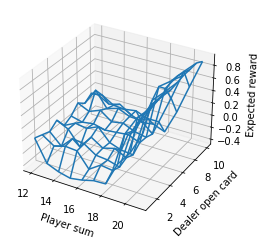

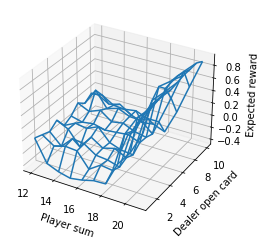

In [20]:
plot_stat(usable_ace_stat)

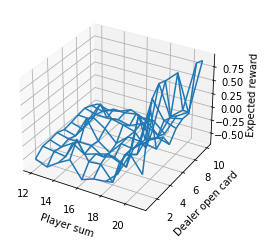

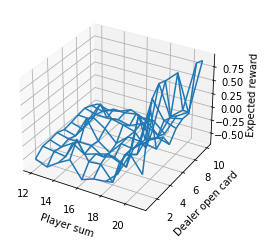

In [21]:
plot_stat(not_usable_ace_stat)